<a href="https://colab.research.google.com/github/kangel429/DeepLearning/blob/master/lesson3_camvid_tiramisu_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image segmentation with CamVid

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [0]:
from google.colab import drive                  #구글 드라이버연결
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git

In [0]:
path = Path('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid')            #파일 경로    

In [0]:
path.ls()                         #파일 경로 체크

[PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/testannot'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/test'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/valannot'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/train'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/val'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/trainannot'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/train.txt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/val.txt'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/test.txt'),
 PosixPath('/content/gdrive/

## Data

In [0]:
fnames = get_image_files(path/'val')      #경로에서 이미지 얻어오기
fnames[:3]                                #3줄까지 검색

[PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/val/0016E5_08123.png'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/val/0016E5_08137.png'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/val/0016E5_08057.png')]

In [0]:
lbl_names = get_image_files(path/'valannot')  #경로에서 이미지 얻어오기
lbl_names[:3]                             #3줄까지 검색

[PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/valannot/0016E5_08123.png'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/valannot/0016E5_08043.png'),
 PosixPath('/content/gdrive/My Drive/Colab Notebooks/course-v3-master/nbs/SegNet-Tutorial/CamVid/valannot/0016E5_08095.png')]

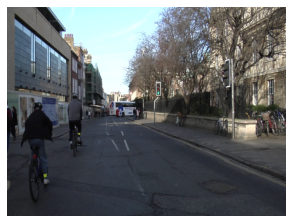

In [0]:
img_f = fnames[0]                            #fnames 0번째 이미지 가지고 오기
img = open_image(img_f)                   #이미지 열어서
img.show(figsize=(5,5))                   #이미지 보여주기

In [0]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',    #클래스 분류 
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

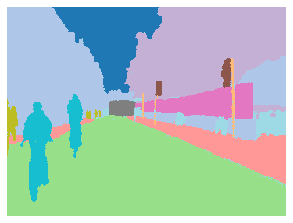

In [0]:
mask = open_mask(get_y_fn(img_f))         #정수값이어서 open mask함수 사용
mask.show(figsize=(5,5), alpha=1)           #마스크로 되어있는 이미지 보여주기

In [0]:
src_size = np.array(mask.shape[1:])     #1 == 빌딩 하늘색  5== 나무 보라색
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

## Datasets

In [0]:
bs = 8                      #한번에 학습할 이미지 8개

In [0]:
src = (SegmentationItemList.from_folder(path)           #이 소스는 어떤 폴더에 위치에서 가져왔고 어떤 레이블로 구성되어있는지
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))      #classes=codes 어떤 픽셀이 각 픽셀 레이블에 해당하는지 알려준다

In [0]:
data = (src.transform(get_transforms(), tfm_y=True)   #y축으로 변형은 허용 이 소스의 모양 데이터 브런치를 만들고 노멀라이즈 해준다
        .databunch(bs=bs) 
        .normalize(imagenet_stats))     

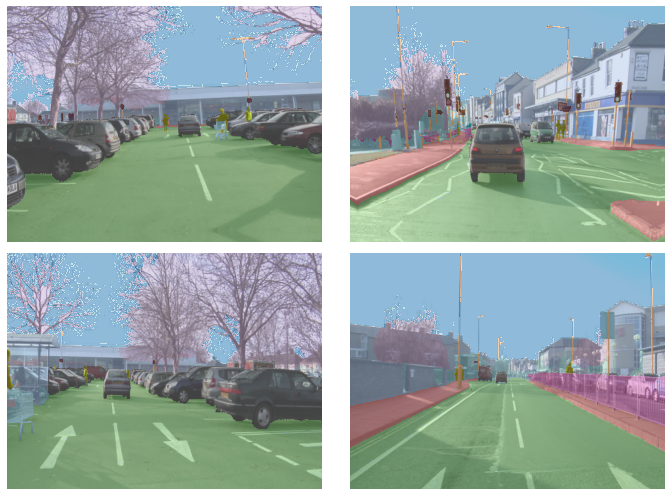

In [0]:
data.show_batch(2, figsize=(10,7))              #이 데이터를 보여준다 2행으로

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
wd=1e-2

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True)     #resnet34 모델을 사용

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


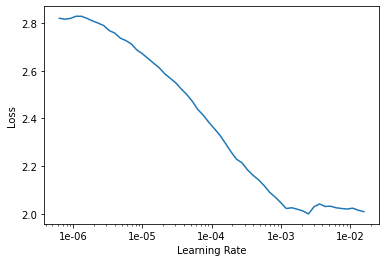

In [0]:
lr_find(learn)                            # 최적의 속도 비율 찾기
learn.recorder.plot()          # 그래프를 통해 보여주기

In [0]:
lr=2e-3               #경사가 급격히 떨어지는 곳이 최적의 속도

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)   # 10번 학습 

epoch,train_loss,valid_loss,acc_camvid,time
0,1.142464,0.796420,0.774578,01:05
1,0.782852,0.523621,0.853545,00:26
2,0.636924,0.551027,0.863188,00:27
3,0.550253,0.553653,0.838627,00:26
4,0.497148,0.519530,0.832141,00:26
5,0.479353,0.651727,0.841697,00:26
6,0.482318,0.506761,0.859086,00:26
7,0.440147,0.336051,0.907802,00:26
8,0.389257,0.344023,0.886840,00:27
9,0.341219,0.281561,0.909383,00:26


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/100,lr)

In [0]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.290731,0.277128,0.908443,00:28
1,0.282796,0.280092,0.916042,00:28
2,0.273626,0.271670,0.917375,00:28
3,0.271136,0.317283,0.898290,00:28
4,0.293165,0.345893,0.901987,00:28
5,0.302314,0.316046,0.912918,00:28
6,0.300035,0.295114,0.917868,00:28
7,0.286204,0.307670,0.903961,00:28
8,0.315418,0.349725,0.907669,00:28
9,0.299304,0.373983,0.904364,00:28


In [0]:
learn.save('stage-2');

## Go big

In [0]:
learn=None
gc.collect()

46

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [0]:
size = src_size    #사이즈를 같게 하면 메모리가 부족할 수 있지만 이것은 배치사이즈를 줄이면 해결된다
bs=8

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, bottle=True).load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


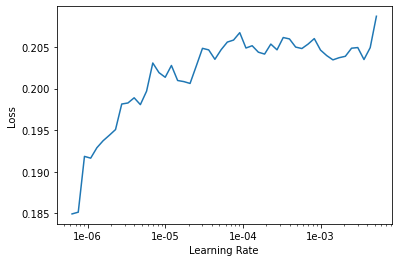

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [0]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.202522,0.257214,0.928254,00:27
1,0.199833,0.244625,0.931204,00:27
2,0.196833,0.253260,0.930842,00:27
3,0.192196,0.280313,0.922131,00:27
4,0.193801,0.273575,0.926113,00:27
5,0.193847,0.281398,0.926754,00:27
6,0.190410,0.248780,0.932717,00:26
7,0.188103,0.266750,0.927392,00:26
8,0.181943,0.232758,0.940396,00:26
9,0.170732,0.244266,0.936056,00:26


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/1000,lr/10)

In [0]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.157322,0.247811,0.935125,00:28
1,0.156484,0.241238,0.937871,00:28
2,0.157361,0.248972,0.935467,00:28
3,0.155825,0.254608,0.935884,00:28
4,0.153982,0.251109,0.935739,00:28
5,0.151693,0.247200,0.937108,00:28
6,0.149707,0.244611,0.938248,00:28
7,0.148170,0.247757,0.936997,00:28
8,0.148353,0.246189,0.937430,00:28
9,0.146501,0.247928,0.936968,00:28


In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

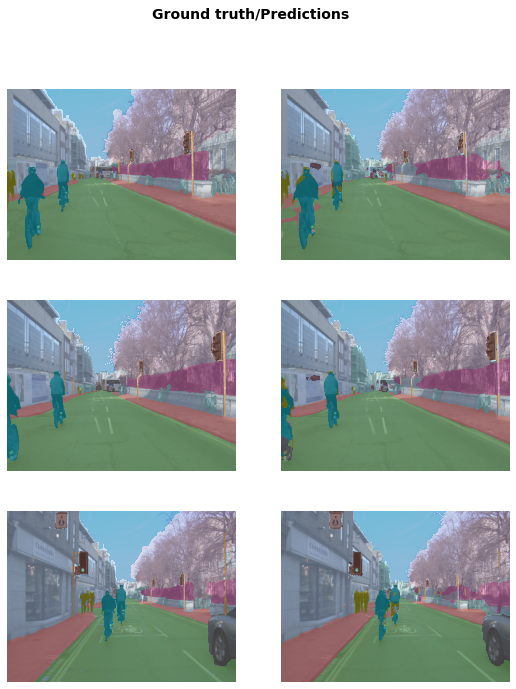

In [0]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [0]:
# start: 480x360

In [0]:
print(learn.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 180, 240]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 180, 240]       128        True      
______________________________________________________________________
ReLU                 [64, 180, 240]       0          False     
______________________________________________________________________
MaxPool2d            [64, 90, 120]        0          False     
______________________________________________________________________
Conv2d               [64, 90, 120]        36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 90, 120]        128        True      
______________________________________________________________________
ReLU                 [64, 90, 120]        0          False     
__________________________________________________